In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle
from scipy import stats

import csv
import sys
import pandas as pd
import os

finalPred = True
fset = 0 # 0 = open data, 1-7 = fake datasets, 8 = High E far sideband, 9 = Low BDT far sideband
cutMode = 0 # 0 = Final Selection, 1 = Kin Cut Sample, 2 = High E, 3 = Low BDT
if fset==8: cutMode = 2
if fset==9: cutMode = 3
    
cutmodedir = {0:'FinalSelection',1:'KinCut',2:'HighE',3:'LowBDT'}[cutMode]

lowEpatch = False#True if fset in [0,5,8,9] else False
vtxCut    = 5

C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17


if fset==0: 
    DAT_POT1 = 4.403e19
    DAT_POT2 = 0
    DAT_POT3 = 8.786e+18
elif fset==1: 
    DAT_POT1  = 1.935765e20
    DAT_POT2 = 0
    DAT_POT3  = 2.99974063e20
elif fset==2: 
    DAT_POT1 = 4.0129213616e20
    DAT_POT2 = 0
    DAT_POT3 = 3.85169302616e20
elif fset==3: 
    DAT_POT1 = 4.024614415411e20
    DAT_POT2 = 0
    DAT_POT3 = 3.9685728933181e20
elif fset==4: 
    DAT_POT1 = 3.907905653e20
    DAT_POT2 = 0
    DAT_POT3 = 3.92356759e20
elif fset==5: 
    DAT_POT1 = 7.00587e20
    DAT_POT2 = 0
    DAT_POT3 = 0
elif fset==7: 
    DAT_POT1 = 1.8382999360024655e+20
    DAT_POT2 = 0
    DAT_POT3 = 2.05E+20
elif(fset==8):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = F1_POT+G1_POT
elif(fset==9):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = G1_POT

if finalPred:
    DAT_POT1 = C1_POT
    DAT_POT2 = E1_POT+D2_POT
    DAT_POT3 = F1_POT+G1_POT
    
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3


print(DAT_POT1,DAT_POT2,DAT_POT3)
print(DAT_POT1+DAT_POT2+DAT_POT3)

def poisson_errors(k, CL = 0.6827): 
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


1.746029e+20 2.6426e+20 2.429524e+20
6.818153e+20


In [2]:
tag='3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'

filetaglist = {1:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0'],
               2:['overlay','overlay_lowE','intrinsics','intrinsics_lowE'],
               3:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0']}

df = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        if not lowEpatch and 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        else:
            pstring = 'SelectionMode%i_%s_fset0_run%i.parquet.gzip'%(cutMode,filetag,r)
        try:
            df[r][filetag] = pd.read_parquet(psavedir+pstring)
            print(len(df[r][filetag]))
        except:
            pass



 #################### RUN 1 #################### 

Sample: data
Sample: ext
281
Sample: overlay
5726
Sample: intrinsics
15031
Sample: ncpi0
599
Sample: ccpi0
292


 #################### RUN 2 #################### 

Sample: overlay
5929
Sample: intrinsics
11487


 #################### RUN 3 #################### 

Sample: data
Sample: ext
568
Sample: overlay
4052
Sample: intrinsics
6074
Sample: ncpi0
525
Sample: ccpi0
272


In [19]:
    

varb_names = ['Enu_1e1p','Eta','PT_1e1p','AlphaT_1e1p',
              'SphB_1e1p','PzEnu_1e1p','ChargeNearTrunk',
              'Q0_1e1p','Q3_1e1p','Thetas','Phis','PTRat_1e1p',
              'Proton_ThetaReco','Proton_PhiReco',
              'MinShrFrac','MaxShrFrac',
              'BjXB_1e1p','BjYB_1e1p','Proton_Edep',
              'Electron_Edep',
              'Lepton_ThetaReco','Lepton_PhiReco',
              'OpenAng','Xreco','Yreco','Zreco',
              'sigprob','MPIDY_muon',
              'MPIDY_proton','MPIDY_eminus','shower_fraction',
              'Shower_Consistency',
              'EnuQE_lepton','EnuQE_proton','EnuTrue']

var_labels = [r'$E_\nu^{Range}$ [MeV]',r'$\eta$',r'Event $p_T$ [MeV]',r'$\alpha_T$',
              'QE Consistency',r'$p_z - E_\nu$ [MeV]','Charge Near Trunk',
              r'$Q_0$ [MeV]',r'$Q_3$ [MeV]',r'$\theta_e + \theta_p$',r'$|\phi_e - \phi_p|$',r'Event $p_T/p$',
              r'$\theta_p$',r'$\phi_p$',
              'Minimum Shower Fraction','Maximum Shower Fraction',
              'Bjorken X (Nucleon Rest Frame)','Bjorken Y (Nucleon Rest Frame)',r'$E_p$ [MeV]',
              r'$E_e$ [MeV]',
              r'$\theta_e$',r'$\phi_e$',
              'Opening Angle',r'$X_{reco}$',r'$Y_{reco}$','$Z_{reco}$',
              '1e1p BDT Score','Muon MPID Score (Y plane)',
              'Proton MPID Score (Y plane)','Electron MPID Score (Y plane)','Shower Fraction',
              'Shower Energy Consistency',
              r'$E_\nu^{Q-e}$',r'$E_\nu^{QE-p}$',r'$E_\nu^{True}$ [MeV]']

ranges = [ (0,1200),(0,0.6),(0,800),(0,np.pi),(0,5000),(-800,300),
           (0,800),(100,700),(0,1400),(0,2*np.pi),(0,2*np.pi),
           (0,1),(0,np.pi),(-np.pi,np.pi),(-1,1),(-1,1),(0,3),
           (0,1),(60,500),(35,1200),(0,np.pi),
           (-np.pi,np.pi),(0,np.pi),(0,256),(-117,117),(0,1036),
           (0.95,1),(0,1),(0,1),(0,1),(0,3),(0,5),
           (0,1200),(0,1200),(0,1200)]

varlabel_dict = {name:label for name,label in zip(varb_names,var_labels)}
range_dict = {name:rnge for name,rnge in zip(varb_names,ranges)}

    

In [20]:
# HELPER FUNCTIONS
detsystag = '5Apr2021'

def getSysErrors(nbins,varName,mode,sigcut):
    try:
        det_sys_m = np.loadtxt('CovMatrices/DetVar/'+tag+'/'+detsystag+'/covMatrix/'+mode+'/BDTcut'+str(sigcut)+'/detsys_'+varName+'_run13_cutMode'+str(cutMode)+'_cov_smooth.csv',delimiter=',')
    except:
        det_sys_m = np.zeros((nbins,nbins))
    try:
        if varName=='sigprob': varName='sigprobavg'
        rwt_sys_m = np.loadtxt('CovMatrices/RwghtSys/frac_covar_rewgt_'+cutmodedir+'__'+varName+'.txt')
    except:
        rwt_sys_m = np.zeros((nbins,nbins))
    rwt_sys_m = np.where(np.isnan(rwt_sys_m),0,rwt_sys_m)
    det_sys_m = np.where(np.isnan(det_sys_m),0,det_sys_m)
    return rwt_sys_m,det_sys_m

def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
    for b in range(nBDTs):
        sp = idf['sigprob%i'%b]
        tvw = idf['tvweight%i'%b]
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=['run','subrun','event'],inplace=True)
    
def SaveTextFile(idf,run,filetag,sigcut,mode,tsavedir):
    nBDTs = int(idf['nBDTs'][0])
    MakeBDTcut(idf,sigcut,mode,nBDTs)
    idf.query('sigprob > @sigcut',inplace=True)
    savestr = 'eventlist_%s_run%i.txt'%(filetag,run)
    idf.to_csv(tsavedir+savestr,index=None,sep=' ')
    
    

In [21]:
mu_cutoff = 0.46149198646840239

def chi2_cnp(M,mu):
    c2c=0
    if mu>0:
        if M != 0:
            c2c = (M - mu)**2/(3 / (2 / mu + 1 / M))
        else:
            c2c = 2*mu#(M - mu)**2/(3 / (2 / mu + 1 / mu))
    return c2c

def chi2_pois(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = 2*(mu - M + M*np.log(M/mu))
        else:
            c2c = 2*mu
    return c2c

def chi2_pears(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = (M-mu)**2 / mu
        else:
            c2c = 2*mu
    return c2c

def chi2_thresh(M,mu,mode='cnp'):
    c2c=0
    if mu > mu_cutoff and mode=='cnp':
        c2c = chi2_cnp(M,mu)
    elif mu > mu_cutoff and mode=='pearson':
        c2c = chi2_pears(M,mu)
    else:
        c2c = chi2_pois(M,mu)
    return c2c

def cov_pois(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (M-mu)**2 / (2*(mu - M + M*np.log(M/mu)))
        else:
            cov = mu/2
    return cov

def cov_cnp(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (3 / (2 / mu + 1 / M))
        else:
            cov = mu/2
    return cov

def cov_pears(M,mu):
    cov=0
    if mu > 0:
        cov = mu
    return cov

def cov_thresh(M,mu,mode='cnp'):
    cov=0
    if mu>mu_cutoff and mode=='cnp':
        cov=cov_cnp(M,mu)
    elif mu>mu_cutoff and mode=='pearson':
        cov=cov_pears(M,mu)
    else:
        cov=cov_pois(M,mu)
    return cov


raw CCQE before cut: 15971.0 +- 126.37642185154634
raw CCQE after cut: 9963.0 +- 99.81482855768475
CCQE accuracy: 0.623818170434 +- 0.007964007381616536
[0.0, 0.07314084254340275, 0.09597037488340258, 0.13169922211201043, 0.12314628402777965, 0.1207841996847938, 0.12671300366744326, 0.11407076554270372, 0.1069727435017069, 0.10109938854190993, 0.09389926745684232, 0.08789417636912925]
[0.         0.07335533 0.70464459 0.57852946 0.20164625 0.15383616
 0.13381855 0.12275078 0.27728415 0.18644244 0.17623582 0.22740618]
0.959822883223


/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:294: RuntimeWarning: invalid value encountered in divide
/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:343: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

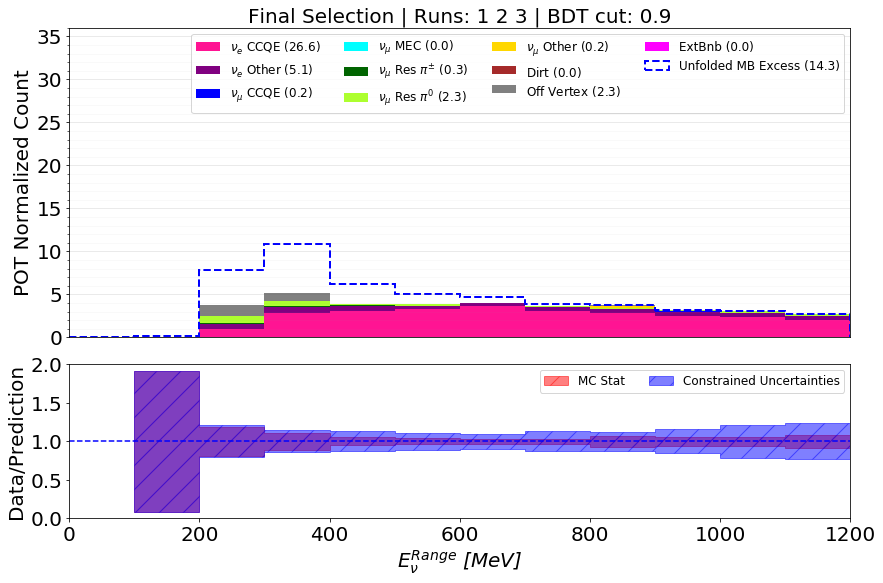

POT scaled nue: 26.551301631809597 +- 0.359073040906
POT scaled total: 36.98421277637858 +- 1.06222558391
Purity: 0.717909065480167 +- 0.022790539158093658
Nue Spectrum: [0.         0.07314084 0.99645772 2.78666307 3.09263174 3.26640705
 3.58962616 3.11479891 2.81402739 2.51403174 2.32671131 1.97680572]
LEE: [ 0.00000000e+00  2.03695288e-02  4.02747853e+00  5.65454280e+00
  2.38054404e+00  1.16511165e+00  6.28552218e-01  2.83152384e-01
  8.75733223e-02  7.50707019e-03  3.64220732e-04 -3.55271368e-14]
Bkg Spectrum: [0.         0.0069078  2.78270143 2.38422229 0.75182024 0.61134782
 0.44707701 0.47751678 0.91563682 0.61818072 0.68041789 0.75708236]
Bkg sum of weights squared: 0.959822883223
POT scaled numu rate: 10.432911144568981
raw CCQE before cut: 15971.0 +- 126.37642185154634
raw CCQE after cut: 9963.0 +- 99.81482855768475
CCQE accuracy: 0.623818170434 +- 0.007964007381616536
[0.0540219309843541, 0.05962677475242049, 0.05233850817101686, 0.06576634941600959, 0.06865093863934839, 0.0

<Figure size 432x288 with 0 Axes>

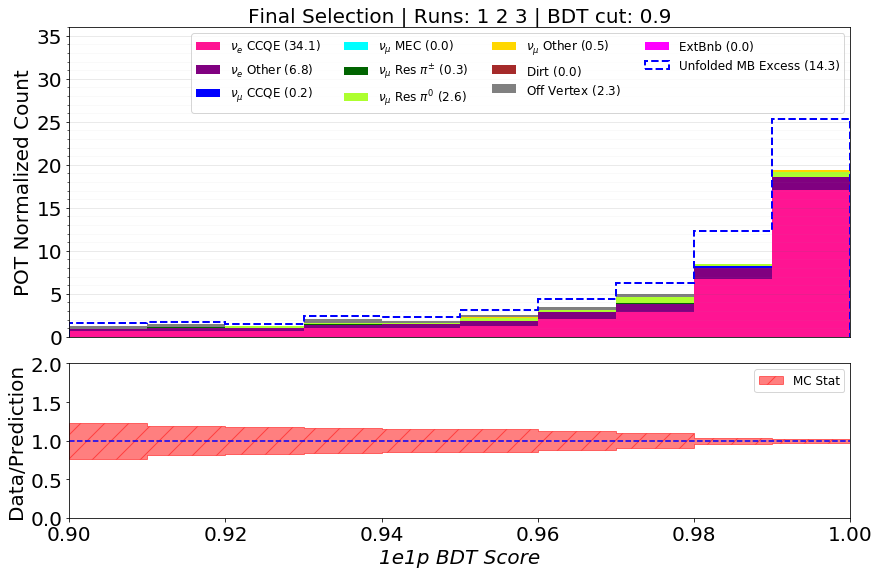

POT scaled nue: 34.05399340906542 +- 0.397796605973
POT scaled total: 46.757391976580045 +- 1.13411886346
Purity: 0.7283125078088715 +- 0.01960741128876312


<Figure size 432x288 with 0 Axes>

In [22]:
fudge_bkg = 1.0
fudge_sig = 1.0
verbose = True
sys     = False
plotPurity = False
bdtmode = 'avgscore'
nBDTs = 20
bdtpower = 0
bdtcutRange = [0.9]
runs_to_plot = [#[1],
                #[2],
                #[3],
                [1,2,3]]

POTdict = {1:{ft:DAT_POT1 for ft in filetaglist[1]},
           2:{ft:DAT_POT2 for ft in filetaglist[2]},
           3:{ft:DAT_POT3 for ft in filetaglist[3]}}
POTdict[3]['ext'] = DAT_POT2 + DAT_POT3
if cutMode in [2,3]:
    POTdict[1]['data'] = DATA_POT_TOT
    
pvals = []


for varName in varb_names:


    
    if varName not in ['Enu_1e1p','sigprob']: continue
    if varName=='EnuTrue' and not finalPred: continue
    
        
    xlab = varlabel_dict[varName]
        
    bins  = 12 if varName in ['Enu_1e1p','EnuQE_proton','EnuQE_lepton','EnuTrue'] else 10
    low   = (range_dict[varName])[0]
    high  = (range_dict[varName])[1]
    
    
    
    for runs_included in runs_to_plot: # [run 1, run 2 run 3]
        
        pRatDict = {}
        pErrDict = {}
        
        for cut in bdtcutRange:
            
            if cutMode in [0,2] and varName=='sigprob': low = cut

            if fset in range(1,8): plotTitle = 'Fake Dataset '+str(fset)+' / Runs:'
            elif cutMode==0: plotTitle = 'Final Selection | Runs:'
            elif cutMode==1: plotTitle = 'Loose Kinematic Cuts | Runs:'
            elif cutMode==2: plotTitle = 'High Energy Sideband | Runs:'
            elif cutMode==3: plotTitle = 'Low BDT Sideband | Runs:'
            plotFileName = varName
            FullPOT = 0
            POT1 = 0
            POT23 = 0

            vars_arr = []
            weights_arr = []
            labels_arr = []
            leew_arr = []

            for r in runs_included:
                plotTitle += ' %i'%r
                plotFileName += '_%i'%r
                FullPOT += POTdict[r]['overlay']
                if r == 1: POT1 += POTdict[r]['overlay']
                elif r in [2,3]: POT23 += POTdict[r]['overlay']

                for filetag in df[r].keys():
                    if not lowEpatch and 'lowE' in filetag: continue
                    dfc = df[r][filetag].copy()
                    #MakeBDTcut(dfc,cut,bdtmode,nBDTs,(r==2 and filetag=='overlay'))
                    MakeBDTcut(dfc,cut,bdtmode,nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
                    
                    
                    vars_arr += list(dfc[varName])
                    numu_l = np.core.defchararray.find(np.array(dfc['label'],dtype=np.string_),'numu')!=-1
                    labels = np.where(np.logical_and(numu_l,dfc['scedr']>vtxCut),'offvtx',dfc['label'])
                    
                    
                    labels_arr += list(labels)

                    weights = dfc['GenieWeight'] * dfc['POTweight']**(-1)
                    if cutMode in [0,2]: weights*= dfc['bdtweight'] * dfc['sigprob']**bdtpower
                    #weights *= dfc['Enu_1e1p']<1200
                    leeweights = dfc['LEEweight'] * weights
                    
                    if filetag!='intrinsics': leeweights*=0

                    weights_arr += list(weights*POTdict[r][filetag])
                    leew_arr += list(leeweights*POTdict[r][filetag])
                

            datLab = "Data: {:.2e} POT".format(FullPOT)
            if cutMode in [0,2]: plotTitle += r' | BDT cut: '+str(cut)



            ## ------------------------ ##

            label_arr = np.array(labels_arr)
            var_arr = np.array(vars_arr)
            weight_arr = np.array(weights_arr)

            data = list(var_arr[label_arr=='data'])
            nueO = list(var_arr[label_arr=='nue_ccqe'])
            nue = list(var_arr[label_arr=='nue_other'])
            ccqe = list(var_arr[label_arr=='numu_ccqe'])
            mec = list(var_arr[label_arr=='numu_mec'])
            pipm = list(var_arr[label_arr=='numu_pipm'])
            pi0 = list(var_arr[label_arr=='numu_pi0'])
            other = list(var_arr[label_arr=='numu_other'])
            dirtVar = []
            offv = list(var_arr[label_arr=='offvtx'])
            extVar = list(var_arr[label_arr=='EXTBNB'])
            lee = list(var_arr)

            ovrw1 = list(fudge_bkg*weight_arr[label_arr=='numu_ccqe'])
            ovrw2 = list(fudge_bkg*weight_arr[label_arr=='numu_mec'])
            ovrw3 = list(fudge_bkg*weight_arr[label_arr=='numu_pipm'])
            ovrw4 = list(fudge_bkg*weight_arr[label_arr=='numu_pi0'])
            ovrw5 = list(fudge_bkg*weight_arr[label_arr=='numu_other'])
            ovrw6 = list(fudge_bkg*weight_arr[label_arr=='offvtx'])
            ovrw7 = list(fudge_sig*weight_arr[label_arr=='nue_other'])
            ovrw8 = list(fudge_sig*weight_arr[label_arr=='nue_ccqe'])
            dirtw = []
            extw = list(weight_arr[label_arr=='EXTBNB'])
            leew = leew_arr
            datw = list(weight_arr[label_arr=='data'])

            d      = plt.hist(data,weights=datw,bins=bins,range=(low,high),normed=0)
            xbins  = [(d[1][i]+d[1][i+1])/2.0 for i in range(len(d[1])-1)]
            xbin_edges = d[1]
            vals = d[0]
            valerrs = poisson_errors(vals)
            binwid = d[1][0]-d[1][1]
            plt.clf()
            
            if verbose:
                A = float(len(ovrw8))
                B = float(sum(np.array(ovrw8)>0))
                print('raw CCQE before cut:',A,'+-',np.sqrt(A))
                print('raw CCQE after cut:',B,'+-',np.sqrt(B))
                print('CCQE accuracy:',B/A,'+-',B/A * np.sqrt(1/A + 1/B))
            



            wghs = [[x for x in ovrw8],
                    [x for x in ovrw7],
                    [x for x in ovrw1],
                    [x for x in  ovrw2],
                    [x for x in ovrw3],
                    [x for x in  ovrw4],
                    [x for x in ovrw5],
                    [x for x in dirtw],
                    [x for x in ovrw6],
                    [x for x in extw],
                    [x for x in leew]]

            mcErW = [[x**2 for x in ovrw8],
                     [x**2 for x in ovrw7],
                     [x**2 for x in ovrw1],
                     [x**2 for x in  ovrw2],
                     [x**2 for x in ovrw3],
                     [x**2 for x in  ovrw4],
                     [x**2 for x in ovrw5],
                     [x**2 for x in dirtw],
                     [x**2 for x in ovrw6],
                     [x**2 for x in extw]]
            


            r = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar],bins=bins,range=(low,high),stacked='True',normed=0,weights=mcErW)
            nueO_mcErr  = [sqrt(r[0][0][i]- 0) for i in range(bins)]
            nue_mcErr   = [sqrt(r[0][1][i]-r[0][0][i]) for i in range(bins)]
            ccqe_mcErr  = [sqrt(r[0][2][i]-r[0][1][i]) for i in range(bins)]
            mec_mcErr   = [sqrt(r[0][3][i]-r[0][2][i]) for i in range(bins)]
            pipm_mcErr  = [sqrt(r[0][4][i]-r[0][3][i]) for i in range(bins)]
            pi0_mcErr   = [sqrt(r[0][5][i]-r[0][4][i]) for i in range(bins)]
            other_mcErr = [sqrt(r[0][6][i]-r[0][5][i]) for i in range(bins)]
            dirt_mcErr  = [sqrt(r[0][7][i]-r[0][6][i]) for i in range(bins)]
            offv_mcErr  = [sqrt(r[0][8][i]-r[0][7][i]) for i in range(bins)]
            ext_mcErr   = [sqrt(r[0][9][i]-r[0][8][i]) for i in range(bins)]
            stkerr =  [sqrt( 
                       nueO_mcErr[i]**2  + 
                       nue_mcErr[i]**2  + 
                       ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(bins) 
                      ]
            stkerr = np.array(stkerr)
            bkgErr = sum([ (ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(bins) 
                      ])


            if(verbose):
                print(nueO_mcErr)
                print(stkerr)
                print(bkgErr)

            plt.clf()

            pli = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar,lee],bins=bins,range=(low,high),weights=wghs,stacked='True',normed=0)
            plt.clf()

            nums = [sum(x for x in pli[0][0]           ),
                    sum(x for x in pli[0][1] -pli[0][0]),
                    sum(x for x in pli[0][2] -pli[0][1]),
                    sum(x for x in pli[0][3] -pli[0][2]),
                    sum(x for x in pli[0][4] -pli[0][3]),
                    sum(x for x in pli[0][5] -pli[0][4]),
                    sum(x for x in pli[0][6] -pli[0][5]),
                    sum(x for x in pli[0][7] -pli[0][6]),
                    sum(x for x in pli[0][8] -pli[0][7]),
                    sum(x for x in pli[0][9] -pli[0][8]),        
                    sum(x for x in pli[0][10]-pli[0][9]),
                    sum(x for x in vals)
                    ]


            cls  = ['deeppink','purple','blue','cyan','darkgreen','greenyellow','gold','brown','gray','fuchsia']
            labs = [r'$\nu_e^{ }$ CCQE (%.1f)'%nums[0],
                    r'$\nu_e^{ }$ Other (%.1f)'%nums[1],
                    r"$\nu_\mu^{ }$ CCQE (%.1f)"%nums[2],
                    r"$\nu_\mu$ MEC (%.1f)"%nums[3],
                    r"$\nu_\mu$ Res $\pi^{\pm}$ (%.1f)"%nums[4],
                    r"$\nu_\mu$ Res $\pi^0$ (%.1f)"%nums[5],
                    r"$\nu_\mu^{ }$ Other (%.1f)"%nums[6],
                    r"Dirt$_{ }^{ }$ (%.1f)"%nums[7],
                    r"Off Vertex$_{ }^{ }$ (%.1f)"%nums[8],
                    "ExtBnb (%.1f)"%nums[9]]
            
#             labs = [r'$1e1p$ (%.1f)'%nums[0],
#                     r'$1eNp$ (%.1f)'%nums[1],
#                     r"$1\mu 1p$ (%.1f)"%nums[2],
#                     r"$1\mu Np$ (%.1f)"%nums[3],
#                     r"$1\mu N\pi^{\pm}$ (%.1f)"%nums[4],
#                     r"$1\mu N\pi^0$ (%.1f)"%nums[5],
#                     r"$1\mu X$ (%.1f)"%nums[6],
#                     r"Dirt$_{ }^{ }$ (%.1f)"%nums[7],
#                     r"Off Vertex$_{ }^{ }$ (%.1f)"%nums[8],
#                     "ExtBnb (%.1f)"%nums[9]]
            
            ## ----------------------- ##


            fig, ax = plt.subplots(figsize=(14,9.5))
            plt.subplot2grid((100,100),(0,0),colspan=100,rowspan=60)

            p = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar],bins=bins,range=(low,high),weights=wghs[0:-1],stacked='True',color=cls,label=labs,normed=0)
            pl =plt.hist(nueO+nue+ccqe+mec+pipm+pi0+other+dirtVar+offv+extVar+lee,bins=bins,range=(low,high),weights=wghs[0]+wghs[1]+wghs[2]+wghs[3]+wghs[4]+wghs[5]+wghs[6]+wghs[7]+wghs[8]+wghs[9]+wghs[10],stacked='False',histtype='step',lw=2,color='blue',ls='--',label="Unfolded MB Excess (%.1f)"%nums[10])
            if not finalPred: plt.errorbar(xbins,vals,xerr=binwid/2,yerr=valerrs,marker='D',ls='None',color='black',ms=4,label="%s (%i)"%(datLab,nums[11]),elinewidth=1.5)
            
            ylow  = 0
            yhigh = 2.5*max(vals)
            if finalPred: yhigh = 12*len(runs_included)

            
            major_xticks = arange(low, high*1.01, 20)
            minor_xticks = arange(low, high*1.01, 5)
            major_yticks = arange(ylow, yhigh+1, 50)
            minor_yticks = arange(ylow, yhigh+1, 10)




            if(sys):
                rwt_sys_m,det_sys_m = getSysErrors(bins,varName,bdtmode,cut)
                sys_label = 'Full Systematics + MC Stat'
            else:
                rwt_sys_m = np.zeros((bins,bins))
                det_sys_m = np.zeros((bins,bins))
                sys_label = 'MC Stat'
            rwt_sys = np.array([rwt_sys_m[j][j] for j in range(bins)])
            det_sys = np.array([det_sys_m[j][j] for j in range(bins)])
            sys_errs = np.sqrt(rwt_sys + det_sys + stkerr**2/p[0][-1]**2)
            
            if not finalPred:
                cov = np.zeros((bins,bins))
                for j in range(bins):
                    cov[j][j] = cov_thresh(vals[j],p[0][-1][j]) + stkerr[j]**2
                cov += det_sys_m * np.outer(p[0][-1],p[0][-1])
                cov += rwt_sys_m * np.outer(p[0][-1],p[0][-1])


                mask2D = np.where(cov==0,False,True)
                mask1D = np.where(p[0][-1]==0,False,True)
                

                Del = (vals - p[0][-1])[mask1D]
                cov = cov[mask2D].reshape((len(Del),len(Del)))

                chi2 = np.matmul(np.matmul(Del,np.linalg.inv(cov)),Del)
                pval = 1 - stats.chi2.cdf(chi2,len(Del))
                pvals.append(pval)

                plt.title(plotTitle+r' | $\chi^2$/NDF (pval): %2.2f/%i (%2.2f) '%(chi2,len(Del),pval),fontsize=18)
            else:
                plt.title(plotTitle,fontsize=20)
           

            sys_low = np.append((p[0][-1] * (1 - sys_errs)),0)
            rsys_low = np.append(1-sys_errs,0)
            sys_high = np.append((p[0][-1] * (1 + sys_errs)),0)
            rsys_high = np.append(1+sys_errs,0)
            #plt.fill_between(xbin_edges,sys_low,sys_high,step='post',hatch='/',label=sys_label,color='red',edgecolor='black',alpha=0.5)

                

            plt.legend(loc='upper right',fontsize=12,ncol=4)
            plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.17)
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.07)
            plt.yticks(fontsize=20)
            ax.set_yticks(major_yticks)
            ax.set_yticks(minor_yticks,minor=True)
            plt.xticks([])
            plt.ylim((ylow,yhigh))
            plt.xlim((low,high))
            #plt.semilogy()
            plt.ylabel("POT Normalized Count",fontsize=20)

            plt.subplot2grid((100,100),(65,0),colspan=100,rowspan=30)

            rat    = [vals[i]/p[0][-1][i] for i in range(bins)]
            raterr = ([valerrs[0][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(bins)],[valerrs[1][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(bins)])
            if not finalPred: plt.errorbar(xbins,rat,yerr=raterr,xerr=binwid/2.0,marker='D',ls='None',color='black',ms=4,elinewidth=1)
            
            plt.fill_between(xbin_edges,rsys_low,rsys_high,step='post',hatch='/',label=sys_label,color='red',edgecolor='black',alpha=0.5)
            if finalPred and varName=='Enu_1e1p' and runs_included==[1,2,3]:
                cons_sys_low = rsys_low
                cons_sys_high = rsys_high
                cons_sys = np.array([0.20901378808739082,
                                    0.1444013176174152,
                                    0.12968704285562785,
                                    0.10899892762530568,
                                    0.09921274905778553,
                                    0.13171895464815286,
                                    0.12074490444040405,
                                    0.15485056693126997,
                                    0.21437910258176504,
                                    0.2357440794006659,0])
                cons_sys_low[2:] = 1 - cons_sys
                cons_sys_high[2:] = 1 + cons_sys
            
                plt.fill_between(xbin_edges,cons_sys_low,cons_sys_high,step='post',hatch='/',label='Constrained Uncertainties',color='blue',edgecolor='black',alpha=0.5)
            
            
            plt.legend(loc='upper right',fontsize=12,ncol=4)
            plt.axhline(y=1.0,ls='--',color='blue')
            plt.xlabel(xlab,fontsize=20,style='italic')
            plt.ylabel("Data/Prediction",fontsize=20)
            plt.ylim((0,2))
            plt.xlim((low,high))
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            ax.set_xticks(major_xticks)
            ax.set_xticks(minor_xticks,minor=True)

            plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_cutLevel3.png',dpi=100)
            plt.show()
            plt.clf()

            sig = p[0][0]
            bkg = p[0][-1] - p[0][0]
            if verbose: 
                A = sum(sig)
                B = sum(sig)+sum(bkg)
                errA = sqrt(sum(np.array(nueO_mcErr)**2))
                errB = sqrt(sum(stkerr**2))
                print('POT scaled nue:',A,'+-',errA)
                print('POT scaled total:',B,'+-',errB)
                print('Purity:',A/B,'+-',A/B*np.sqrt(errA**2/A**2 + errB**2/B**2))
                if varName=='Enu_1e1p':
                    print('Nue Spectrum:',sig)
                    print('LEE:',pl[0]-(sig+bkg))
                    print('Bkg Spectrum:',bkg)
                    print('Bkg sum of weights squared:',bkgErr)
                    print('POT scaled numu rate:',sum(bkg))
                
            #print(sum(sig[2:5])/(sum(sig[2:5])+sum(bkg[2:5])))
            #print(sum(sig)/(sum(sig)+sum(bkg)))

            if plotPurity:
                purityRat = sig / (sig+bkg)
                pratErr = np.sqrt((1.0/(sig+bkg))**2*np.array(nueO_mcErr)**2 +
                                 (sig/(sig+bkg)**2)**2*np.array(stkerr)**2)
                pratErr = np.where(np.logical_or(np.isinf(purityRat),np.isnan(purityRat)),1,pratErr)
                purityRat = np.where(np.logical_or(np.isinf(purityRat),np.isnan(purityRat)),1,purityRat)
                plt.errorbar(xbins,purityRat,yerr=pratErr,fmt='.',capsize=3)
                plt.xlabel(xlab)
                plt.title('Purity')
                plt.ylim(0,1)
                plt.ylabel(r'$\frac{sig}{sig + bkg}$',fontsize=15)
                plt.show()
                plt.clf()
            
if not finalPred:
    plt.hist(pvals,bins=10,range=(0,1))
    plt.xlabel('P vals')
    plt.title(plotTitle)
    plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvals.png')         
    plt.show()
            

In [26]:
tsavedir = 'TextFiles/'+tag+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
for bdtmode in ['avgscore','fracweight','medianscore']:
    tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'+bdtmode+'/'
    try: os.mkdir(tsavedir)
    except OSError as error: print(error)
    for r in [1,2,3]:
        for filetag in df[r].keys():
            if not lowEpatch and 'lowE' in filetag: continue
            if not 'data' in filetag: continue
            dfc = df[r][filetag].copy()
            SaveTextFile(dfc,r,filetag+'_fset%i'%fset,0.0,bdtmode,tsavedir)

[Errno 17] File exists: 'TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/'
[Errno 17] File exists: 'TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/'
[Errno 17] File exists: 'TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/'
[Errno 17] File exists: 'TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/fracweight/'
[Errno 17] File exists: 'TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/medianscore/'
